## Analisis de la calibracion

El archivo de calibración definitiva encontró unos parámetros de ajuste con un error elevad y con unos parámetros que no pueden ser físicos (p2 del polarizador negativo, por ejemplo). Este archivo busca encontrar el error para su subsanación.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from __future__ import print_function, division

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import datetime
import pprint
from math import sqrt, pi

from scipy.io import savemat, loadmat
from scipy.special import erf
from scipy import optimize
from phyton_optics import degrees

import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
from phyton_optics.utils_common import ndgrid

from polarimeter.polarimeter import Intensity_Rotating_Elements
from polarimeter.data_process import process

import polarimeter.polarimeter as opsys
import numpy as np
import os

from polarimeter.utils import dibujar_2d_fitting, plot_2d, plot_experiment_residuals_1D

print('Carga de modulos finalizada')

Carga de modulos finalizada


In [3]:
def dist_angulos(th1,th2, th0=None):
    """Function to calculate the individual angles in order to introduce an experiment of the polarimeter calibration in the function 
    to determine Mueller matrix."""
    
    # Create initial angle distribution
    (N1, N2) = (th1.size, th2.size)
    Nmeas = N1*N2
    angles = np.zeros([4,Nmeas])    
    # fill the medium values
    for ind1 in range(N1):
        for ind2 in range(N2):
            ind3 = ind1*(N1-1) + ind2
#             print([ind1, ind2, ind3])
            if th0 is None:
                angles[1,ind3] = th1[ind1]
                angles[2,ind3] = th2[ind2]   
            else:
                angles[1,ind3] = th1[ind1] + th0[1]
                angles[2,ind3] = th2[ind2] + th0[2]
                angles[0,ind3] = th0[0]
                angles[3,ind3] = th0[3]          
    return angles

def plot_2d_scattered(x, y, z, Nxy=25, method='linear', title='', color="magma", xy_are_angles=True):
    """Function that plots a 2D surface given by 1D arrays of X, Y and Z by interpolating."""
    # First, we have to interpolate the data. For doing that, we need to create the space where our data is in.
    xspace, yspace = np.linspace(x.min(), x.max(), Nxy), np.linspace(y.min(), y.max(), Nxy)
    xgrid, ygrid = ndgrid(xspace,yspace)
    # Now we can interpolate
    z2d = sp.interpolate.griddata((x, y), z, (xgrid, ygrid), method=method)
    # Plot
    plot_2d(xgrid, ygrid, z2d, title=title, color=color, xy_are_angles=xy_are_angles)

**Cargar datos**

Cargar los datos guardados en los archivos y realizar algunos cálculos para eliminar ruido, por ejemplo.

In [26]:
# Calibracion dia 19
# Load file
filename = 'Paso_4_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
ratio_individual = Iindividual[:,0] / Iindividual[:,1]
mean = np.mean(Iindividual, axis=0)
mean_phd2 = np.mean(Iindividual[:,1])

# Load file
filename = 'Paso_5_2018-12-19.npz'
data = np.load(filename)
# Rename variables
angle1 = data['angle1']
Intensity_Paso5 = data['intensity1']
#Intensity_Paso5 = Intensity_Paso5[:,0] * Intensity_Paso5[:,1]/mean_phd2

# Load file
filename = 'Paso_6_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso6 = data['intensity1']
#Intensity_Paso6 = Intensity_Paso6[:,0] * Intensity_Paso6[:,1]/mean_phd2

# Load file
filename = 'Paso_7_2018-12-19.npz'
data = np.load(filename)
# Rename variables
angles2x = data['angle2x']
angles2y = data['angle2y']
Intensity_Paso7 = data['intensity2']
#Intensity_Paso7 = Intensity_Paso7[:,0] * Intensity_Paso7[:,1]/mean_phd2

# Load file
filename = 'Paso_8a_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8a = data['intensity1']
#Intensity_Paso8a = Intensity_Paso8a[:,0] * Intensity_Paso8a[:,1]/mean_phd2

# Load file
filename = 'Paso_8b_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8b = data['intensity1']
#Intensity_Paso8b = Intensity_Paso8b[:,0] * Intensity_Paso8b[:,1]/mean_phd2

# Load file
filename = 'Paso_8c_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8c = data['intensity1']
#Intensity_Paso8c = Intensity_Paso8c[:,0] * Intensity_Paso8c[:,1]/mean_phd2

# Load file
filename = 'Paso_9_2018-12-19.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso9 = data['intensity2']
#Intensity_Paso9 = Intensity_Paso9[:,0] * Intensity_Paso9[:,1]/mean_phd2

print('Carga de datos finalizada')

Carga de datos finalizada


In [4]:
# Calibracion dia 21
# Load file
filename = 'Paso_4_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
ratio_individual = Iindividual[:,0] / Iindividual[:,1]
mean = np.mean(Iindividual, axis=0)
mean_phd2 = np.mean(Iindividual[:,1])

# Load file
filename = 'Paso_5_2018-12-21.npz'
data = np.load(filename)
# Rename variables
angle1 = data['angle1']
Intensity_Paso5 = data['intensity1']
#Intensity_Paso5 = Intensity_Paso5[:,0] * Intensity_Paso5[:,1]/mean_phd2

# Load file
filename = 'Paso_6_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso6 = data['intensity1']
#Intensity_Paso6 = Intensity_Paso6[:,0] * Intensity_Paso6[:,1]/mean_phd2

# Load file
filename = 'Paso_7_2018-12-21.npz'
data = np.load(filename)
# Rename variables
angles2x = data['angle2x']
angles2y = data['angle2y']
Intensity_Paso7 = data['intensity2']
#Intensity_Paso7 = Intensity_Paso7[:,0] * Intensity_Paso7[:,1]/mean_phd2

# Load file
filename = 'Paso_8a_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8a = data['intensity1']
#Intensity_Paso8a = Intensity_Paso8a[:,0] * Intensity_Paso8a[:,1]/mean_phd2

# Load file
filename = 'Paso_8b_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8b = data['intensity1']
#Intensity_Paso8b = Intensity_Paso8b[:,0] * Intensity_Paso8b[:,1]/mean_phd2

# Load file
filename = 'Paso_8c_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso8c = data['intensity1']
#Intensity_Paso8c = Intensity_Paso8c[:,0] * Intensity_Paso8c[:,1]/mean_phd2

# Load file
filename = 'Paso_9_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso9 = data['intensity2']
#Intensity_Paso9 = Intensity_Paso9[:,0] * Intensity_Paso9[:,1]/mean_phd2

# Load file
filename = 'Paso_11a_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso11a = data['intensity2']

# Load file
filename = 'Paso_11b_2018-12-21.npz'
data = np.load(filename)
# Rename variables
Intensity_Paso11b = data['intensity2']

print('Carga de datos finalizada')

Carga de datos finalizada


In [21]:
print(ps.Stokes_azimuth_ellipticity(az=0, el=42*degrees,intensity=4.7))

[[4.7       ]
 [0.49128378]
 [0.        ]
 [4.67425291]]


## Ajuste conjunto

In [5]:
# Funciones
def model_paso5(par, th1): 
    # Ordenar o no los pes del polarizador
    if ordenarPes:
        p1_c = max(par[0], par[1])
        p2_c = min(par[0], par[1])
        Mpmalo = ps.polarizer_linear(p1=p1_c, p2=p2_c)
    else:
        Mpmalo = ps.polarizer_linear(p1=par[0], p2=par[1])
    # Calcular
    M = [Mpmalo, Mp1]
    th = [0, th1+par[2]]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Ifuente)
    return Iteor
def err_paso5(par, th1, Ireal): 
    Iteor = model_paso5(par, th1)
    diferencia = Iteor - Ireal
    return diferencia

def model_paso6(par, th1): 
    # Create Jones matrices
    M = [Mr2, Mp1]
    # Rotar la fuente para evitar errores
    th_error1 = errAmpIt * erf(par[1])
    th_error2 = el_errAmpIt * erf(par[2])
    Ipaso6 = ps.Stokes_azimuth_ellipticity(
        az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
    # Calcular
    th = [th1+par[0], +th0p1b]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Ipaso6)
    return Iteor
def err_paso6(par, th1, Ireal): 
    Iteor = model_paso6(par, th1)
    diferencia = Iteor - Ireal
    return diferencia

def model_paso7(par, th1, th2):
    # Iluminacion y angulos
    Itest = ps.Stokes_azimuth_ellipticity(
        az=par[1], el=par[2], intensity=par[0], pol_degree=par[3])
    # Calcular
    th_error = errAmpIt * erf(par[4])    
    th = [th1+th0r2b+th_error, th2+th0p1b]  
    M = [Mr2, Mp1]
    I = Intensity_Rotating_Elements(M, th, Itest, False)
    return I
def err_paso7(par, th1, th2, Ireal): 
    dI = model_paso7(par, th1, th2) - Ireal 
    return dI.flatten()

def model_paso8(par, th1a, th1b, th1c): 
    # Ordenar o no los pes del polarizador
    if ordenarPes:
        p1_1 = max(par[0], par[1])
        p2_1 = min(par[0], par[1])
        p1_2 = max(par[2], par[3])
        p2_2 = min(par[2], par[3])
        p1_3 = max(par[4], par[5])
        p2_3 = min(par[4], par[5])
        Mp1 = ps.polarizer_linear(p1=p1_1, p2=p2_1)
        Mp2 = ps.polarizer_linear(p1=p1_2, p2=p2_2)
        Mp3 = ps.polarizer_linear(p1=p1_3, p2=p2_3)
    else:
        Mp1 = ps.polarizer_linear(p1=par[0], p2=par[1])
        Mp2 = ps.polarizer_linear(p1=par[2], p2=par[3])
        Mp3 = ps.polarizer_linear(p1=par[4], p2=par[5])
    # Rotar la fuente para evitar errores
    th_error1 = errAmpIt * erf(par[9])
    th_error2 = el_errAmpIt * erf(par[10])
    Ipaso8 = ps.Stokes_azimuth_ellipticity(
        az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
    # First, P3 and P1   
    M = [Mp3, Mp1]
    th = [th1a+par[6], +th0p1b]
    Ia = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # Then, P3 and P2   
    M = [Mp3, Mp2]
    th = [+par[6], th1b+par[7]]
    Ib = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # Last, P1 and P2  
    M = [Mp1, Mp2]
    th = [th1c+par[8], +par[7]]
    Ic = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # End
    return (Ia, Ib, Ic)
def err_paso8(par, th1a, th1b, th1c, IRa, IRb, IRc): 
    (Ia, Ib, Ic) = model_paso8(par, th1a, th1b, th1c)
    dIa = Ia - IRa
    dIb = Ib - IRb
    dIc = Ic - IRc
    dI = np.concatenate((dIa, dIb, dIc))
    return dI

def model_paso9(par, th1, th2):
    # Crear matrices
    Mr2 = ps.Mueller_Real_Retarder(par[0], par[1], par[2])
    Mp1 = ps.Mueller_Real_Retarder(p11, p12, par[4])
    # Rotar la fuente para evitar errores
    th_error = errAmpIt * erf(par[5])
    th_error1 = errAmpIt * erf(par[6])
    th_error2 = el_errAmpIt * erf(par[7])
    Ipaso9 = ps.Stokes_azimuth_ellipticity(
        az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
    # Calcular
    M = [Mp1, Mr2, Mp2]
    th = [th1+th0p1+th_error, +par[3], th2+th0p2]
    I = Intensity_Rotating_Elements(M, th, Ipaso9, False)
    return I
def err_paso9(par, th1, th2, Ireal): 
    dI = model_paso9(par, th1, th2) - Ireal
    return dI.flatten()

def model_paso11a(par, th1, th2):
    Mr1 = ps.Mueller_Real_Retarder(par[0], par[1], par[2])
    # Rotar la fuente para evitar errores
    th_error = errAmpIt * erf(par[6])
#     th_error1 = errAmpIt * erf(par[5])
#     th_error2 = errAmpIt * erf(par[6])
#     th_error3 = errAmpIt * erf(par[7])
#     th_error4 = errAmpIt * erf(par[8])
#     Ipaso11a = ps.Stokes_azimuth_ellipticity(
#         az=Saz+th_error3, el=Sel+th_error4, intensity=S0, pol_degree=Spol)
    # Calcular
    M = [Mp1, Mr1, Mr2, Mp2]
    th = [par[4], th1+par[3], th2+th0r2+th_error, par[5]]
    I = Intensity_Rotating_Elements(M, th, Ifuente)
    return I
def err_paso11a(par, th1, th2, Ireal): 
    dI = model_paso11a(par, th1, th2) - Ireal
    return dI.flatten()

def model_paso11b(th1, th2):
    # Calcular
    M = [Mp1, Mr1, Mr2, Mp2]
    th = [th0p1c, th1+th0r1, th2+th0r2, th0p2c+pi/2]
    I = Intensity_Rotating_Elements(M, th, Ifuente)
    return I

Iteracion 0


d:\codigo\phyton_optics\phyton_optics\utils_common.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  m2[:, ind] = np.squeeze(m[:, ind2])


Error del ultimo paso: 0.000572722677747.
Iteracion 1
Error del ultimo paso: 0.00178454702751.
Iteracion 2
Error del ultimo paso: 0.00186023537325.
Iteracion 3
Error del ultimo paso: 0.00213574772369.
Iteracion 4
Error del ultimo paso: 0.00055915133111.
Iteracion 5
Error del ultimo paso: 0.000717166987717.
Iteracion 6
Error del ultimo paso: 0.00071383284648.
Iteracion 7
Error del ultimo paso: 0.00071394882007.
Iteracion 8
Error del ultimo paso: 0.000684397055509.
Iteracion 9
Error del ultimo paso: 0.000682612121824.
Iteracion 10
Error del ultimo paso: 0.000683088227755.
Iteracion 11
Error del ultimo paso: 0.000682695533044.
Iteracion 12
Error del ultimo paso: 0.00068217504073.
Iteracion 13
Error del ultimo paso: 0.000681854980155.
Iteracion 14
Error del ultimo paso: 0.000681721824914.
Iteracion 15
Error del ultimo paso: 0.00068173340601.
Iteracion 16
Error del ultimo paso: 0.000681856356037.
Iteracion 17
Error del ultimo paso: 0.000682056069725.
Iteracion 18
Error del ultimo paso: 0.00

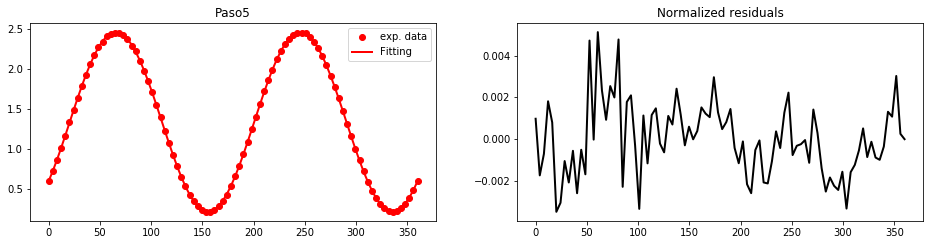

Parametros del paso 6
Th0r2b = 33.2550119335 deg; Th0E_az = -1.00623058987 deg; Th0E_el = 0.0335410196625 deg;
Error del paso 6: 0.000255823717487.


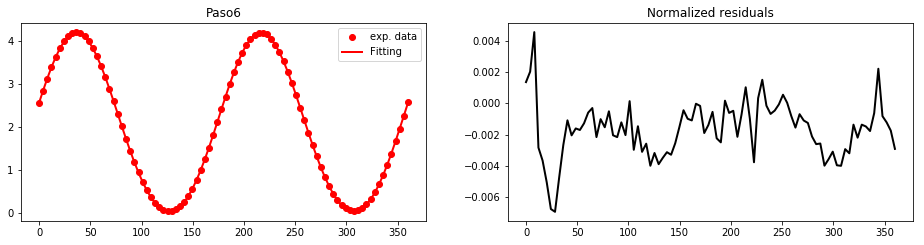

Parametros del paso 7
S0 = 4.68989633243 V; Azimuth = 21.4328847204 deg; Ellipticity = 42.3664097358 deg; Pol. degree = 1.0; Th0_error = -0.020889677378 deg;
Error del paso 7: 0.000308959598864.
Parametros del paso 8
p11 = 0.959515602139; p12 = 0.0594496747129; p21 = 0.962277562598; p22 = 0.0801476110104; p31 = 0.958656158642; p32 = -0.0470872057594;
Th0p1 = 38.7730172939 deg; Th0p2 = 136.58299595 deg; Th0p3 = 128.891416483 deg; Th0E_az = 0.226101185845 deg; Th0E_el = -0.0335410196625 deg;
Error del paso 8: 0.000186937772805.


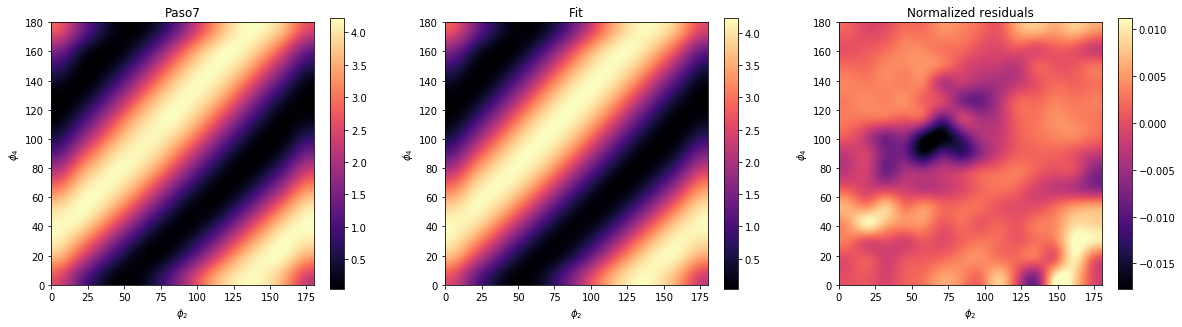

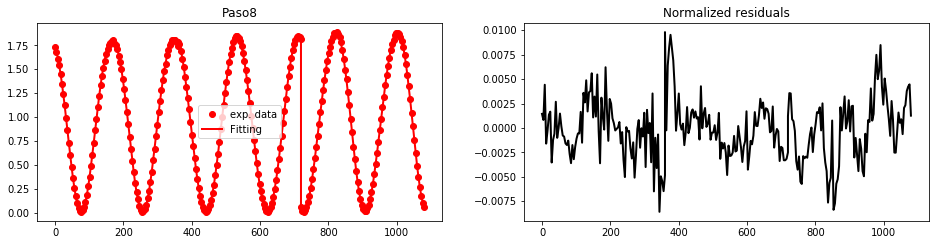

Parametros del paso 9
R2p1 = 0.982290646563; R2p2 = 0.999784924803; Delay_R2 = 81.9933459298; Th0_R2 = 100.378918745; Delay_p1 = 129.416079787;
Th0_error = -1.00623058987; Th0E_az = -1.00623058987; Th0E_az = 0.0335410196625;
Error del paso 9: 0.000919794327912.
Parametros del paso 11a
R1p1 = -0.989175327833; R1p2 = -0.997665223367; Delay_R1 = 82.6091902835; Th0_R1 = 18.7472698826;
Error del paso 11a: 0.000682614016665.
Error del paso 11b: 0.000776598301598.
La matriz del vacío es:
[[ 1.00082636  0.00082083  0.00009547 -0.        ]
 [ 0.00238531  0.99431065 -0.00641436  0.        ]
 [ 0.0003551   0.00686797  0.99655368  0.        ]
 [-0.          0.          0.          0.99286956]]
Error matriz del vacío: 0.000862824866152.
Error del ultimo paso: 0.000682614016665.
Elapsed time is 269.375999928 s.


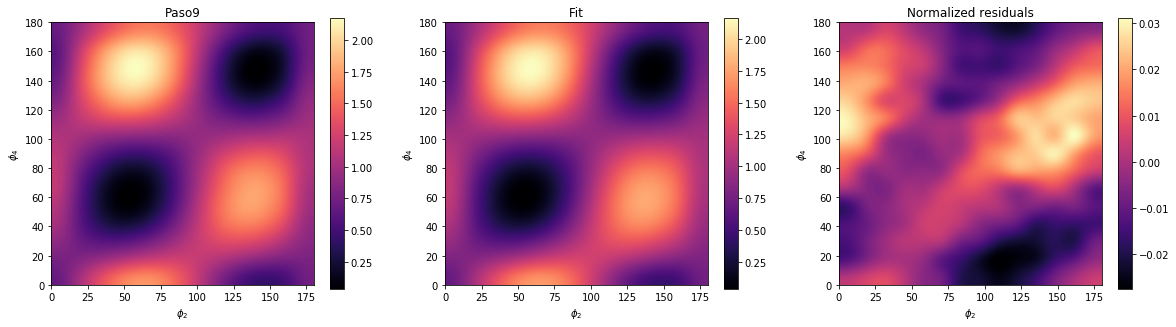

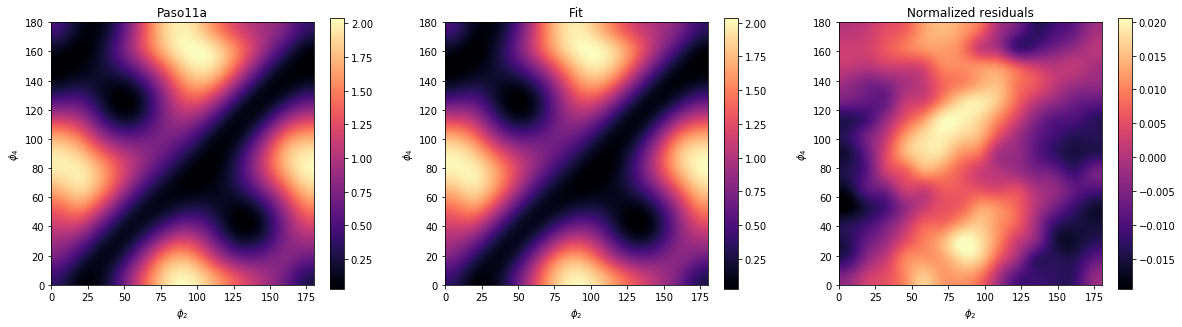

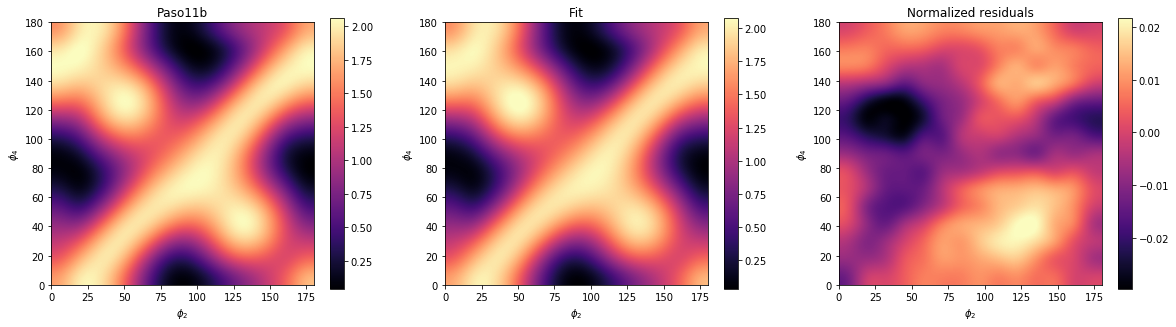

In [6]:
# Parametros del bucle
NmaxIteraciones = 20
tolerancia = 1e-4
PlotCadaPaso = False
ordenarPes = True
tol_while = 2.5e-4
N_it_while = 10
use_random_angles = True
fix_parameters = True
hacer_paso_11 = True
# Parametros iniciales
(p11, p12, Dp1, p21, p22, p31, p32, pc1, pc2) = (0.95, 0.15, 0*degrees, 0.95, 0.15, 0.95, 0.15, 0.95, 0.3)
(R2p1, R2p2, Dr2) = (0.99, 0.99, 85*degrees)
Mp1 = ps.polarizer_linear(p1=p11, p2=p12)
Mr2 = ps.Mueller_Real_Retarder(R2p1, R2p2, Dr2)
(S0, Saz, Sel, Spol) = (mean[0], 0, 44*degrees, 1)
Ifuente = ps.Stokes_azimuth_ellipticity(az=Saz, el=Sel, intensity=S0, pol_degree=Spol)
(th0p1b, th0p1, th0p2, th0p3, th0r2, th0r2b) = (0, 0, 0, 0, 0, 0)
(R1p1, R1p2, Dr1, th0r1, th0p1c, th0p2c) = (0.99, 0.99, 85*degrees, 0, 0, 0)
# Parametros asociados a tolerancia de errores
(th0E0, errAmp, el_errAmp, exp_crec, max_change, el_max_change) = (0, 90*degrees, 3*degrees, 1.5, 20*degrees, 1*degrees)
(errAmpIt, el_errAmpIt) = (errAmp, el_errAmp)
# Inicializar donde guardo los datos de cada iteracion
errores = np.zeros([NmaxIteraciones, 8])
pes = np.zeros([NmaxIteraciones, 12])
ilums = np.zeros([NmaxIteraciones, 4])
delays = np.zeros([NmaxIteraciones, 3])
fangles = np.zeros([NmaxIteraciones, 9])
errangles = np.zeros([NmaxIteraciones, 9])
Nelements1D = angle1.size
Nelements2D = angles2x.size * angles2y.size

# Hacer el bucle
start_time = time.time()
for indIt in range(NmaxIteraciones):
    # Actualizar amplitud de error por iteracion
    errAmptest = errAmp / (indIt+1)**exp_crec
    errAmpIt = max(errAmptest, errAmpIt-max_change)
    el_errAmptest = el_errAmp / (indIt+1)**exp_crec
    el_errAmpIt = max(el_errAmptest, el_errAmpIt-el_max_change)
    if not use_random_angles:
        NmaxIteraciones = 1
    print('Iteracion {}'.format(indIt))
    if PlotCadaPaso:
        print('Amplitud de error en angulos = {}'.format(errAmpIt/degrees))
        
    ## Comenzar por ajustar el angulo de P1 en el motor 4 (Paso 5)
    (contador, error_Paso, mejor_error) = (0, 1, 1)
    while contador < N_it_while and error_Paso > tol_while:
        # Inicializar angulo en la primera iteracion
        if indIt == 0 and use_random_angles:
            th0p1b = np.random.rand(1)*pi
            th0p1b = th0p1b[0]
        # Parametros iniciales
        par0 = [pc1, pc2, th0p1b]
        # Normalizacion de intensidades experimentales en funcion de la referencia
        Iexperimental = Intensity_Paso5[:,0] * Intensity_Paso5[:,1]/mean[1]
        # Ajuste
        par1, success = optimize.leastsq(err_paso5, par0, args=(angle1*degrees, Iexperimental))
        # Calculo de errores
        error_Paso = err_paso5(par1, angle1*degrees, Iexperimental)
        error_Paso = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements1D)
        # Guardar mejores resultados
        if error_Paso < mejor_error:
            par_mejor = par1
            mejor_error = error_Paso
        # Operaciones final de bucle        
        contador = contador + 1
        if PlotCadaPaso and N_it_while > 1:
            print('Subiteracion {} da error {}.'.format(contador, error_Paso))
    # Guardar resultados
    pc1 = max(par_mejor[0], par_mejor[1])
    pc2 = min(par_mejor[0], par_mejor[1])    
    (pes[indIt, 8], pes[indIt, 9]) = (pc1, pc2)
    fangles[indIt, 4] = th0p1b
    errores[indIt, 0] = mejor_error
    # Extraer resultados para siguientes iteraciones. Hay que tener en cuenta que 
    # el valor del angulo debe cambiar en 90º si el parametro correspondiente a p1
    # es menor que el de p2
    if pc1 == par_mejor[0]:
        th0p1b = par_mejor[2]%pi
    else:
        th0p1b = (par_mejor[2]+pi/2)%pi            
    # Plots
    if PlotCadaPaso or indIt+1 == NmaxIteraciones:
        print("Parametros del paso 5")
        print("pc1 = {}; pc2 = {}; Th0p1b = {} deg;".format(par_mejor[0], par_mejor[1], (par_mejor[2]%pi)/degrees))
        print("Error del paso 5: {}.".format(errores[indIt, 0]))
        I_fit = model_paso5(par_mejor, angle1*degrees)
        plot_experiment_residuals_1D(angle1*degrees, Iexperimental, I_fit,  title='Paso5')
    
    
    ## Ahora el del retardador 2 la primera vez que lo metimos (Paso 6)
    (contador, error_Paso, mejor_error) = (0, 1, 1)
    while contador < N_it_while and error_Paso > tol_while:
        # Inicializar angulo en la primera iteracion
        if indIt == 0 and use_random_angles:
            th0r2b = np.random.rand(1)*pi   
            th0r2b = th0r2b[0]
#             Saz = np.rando+.random.rand(1))*degrees
        # Parametros iniciales
        par0 = [th0r2b, th0E0, th0E0]
        # Normalizacion de intensidades experimentales en funcion de la referencia
        Iexperimental = Intensity_Paso6[:,0] * Intensity_Paso6[:,1]/mean[1]
        # Ajuste
        par1, success = optimize.leastsq(err_paso6, par0, args=(angle1*degrees, Iexperimental))  
        # Calculo de errores
        error_Paso = err_paso6(par1, angle1*degrees, Iexperimental)
        error_Paso = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements1D)
        # Guardar mejores resultados
        if error_Paso < mejor_error:
            par_mejor = par1
            mejor_error = error_Paso
            Saz_mejor = Saz
            Sel_mejor = Sel
        # Operaciones final de bucle        
        contador = contador + 1
        if PlotCadaPaso and N_it_while > 1:
            print('Subiteracion {} da error {}.'.format(contador, error_Paso))
    # Extraer resultados para siguientes iteraciones
    th0r2b = par_mejor[0]%pi
    th_error1 = errAmpIt * erf(par_mejor[1])
    th_error2 = el_errAmpIt * erf(par_mejor[2])
    # Guardar resultados
    fangles[indIt, 5] = th0r2b
    errangles[indIt, 0:2] = (th_error1, th_error2)
    errores[indIt, 1] = mejor_error
    # Plots
    if PlotCadaPaso or indIt+1 == NmaxIteraciones:
        print("Parametros del paso 6")
        print("Th0r2b = {} deg; Th0E_az = {} deg; Th0E_el = {} deg;".format(
            (par_mejor[0]%pi)/degrees, th_error1/degrees, th_error2/degrees))
        print("Error del paso 6: {}.".format(errores[indIt, 1]))
        I_fit = model_paso6(par_mejor, angle1*degrees)
        plot_experiment_residuals_1D(angle1*degrees, Iexperimental, I_fit,  title='Paso6')
    # Arreglar parametros anteriores que el nuevo ajuste pide cambiar
    if fix_parameters:
        Saz = Saz_mejor + th_error1
        Sel = Sel_mejor + th_error2        
        Ipaso6 = ps.Stokes_azimuth_ellipticity(
            az=Saz, el=Sel, intensity=S0, pol_degree=Spol)
        
    
    ## Vamos a ajustar la iluminacion (Paso 7)
    # Parametros iniciales
    par0 = [S0, Saz, Sel, Spol, th0E0]
    # Normalizacion de intensidades experimentales en funcion de la referencia
    Iexperimental = Intensity_Paso7[:,:,0] * Intensity_Paso7[:,:,1]/mean[1]
    #Iexperimental = np.transpose(Iexperimental)
    # Ajuste
    par1, success = optimize.leastsq(err_paso7, par0, args=(angles2x*degrees, angles2y*degrees, Iexperimental))
    # Extraer resultados para siguientes iteraciones
    (S0, Saz, Sel, Spol) = par1[0:4]
    Ifuente = ps.Stokes_azimuth_ellipticity(az=Saz, el=Sel, intensity=S0, pol_degree=Spol)
    th_error = errAmpIt * erf(par1[4])
    # Guardar resultados
    ilums[indIt, 0:4] = (S0, Saz, Sel, Spol)
    errangles[indIt, 2] = th_error
    # Calculo de errores
    error_Paso = err_paso7(par1, angles2x*degrees, angles2y*degrees, Iexperimental)
    errores[indIt, 2] = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements2D)
    # Plots
    if PlotCadaPaso or indIt+1 == NmaxIteraciones:
        print("Parametros del paso 7")
        print("S0 = {} V; Azimuth = {} deg; Ellipticity = {} deg; Pol. degree = {}; Th0_error = {} deg;".format(
            par1[0], par1[1]/degrees, par1[2]/degrees, par1[3], th_error/degrees))
        print("Error del paso 7: {}.".format(errores[indIt, 2]))
        I_fit = model_paso7(par1, angles2x*degrees, angles2y*degrees) 
        plt.figure(figsize=(20, 5))       
        plt.subplot(1,3,1)
        plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso7')    
        plt.subplot(1,3,2)
        plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
        plt.subplot(1,3,3)
        plot_2d(angles2x*degrees, angles2y*degrees,  (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
    # Arreglar parametros anteriores que el nuevo ajuste pide cambiar
    if fix_parameters:
        th0p1b = th0p1b + th_error
        
    
    ## Ahora vamos a por los polarizadores (Paso 8)
    (contador, error_Paso, mejor_error) = (0, 1, 1)
    while contador < N_it_while and error_Paso > tol_while:
        # Inicializar angulo en la primera iteracion
        if indIt == 0 and use_random_angles:
            (th0p1, th0p2, th0p3) = np.random.rand(3)*pi
        # Parametros iniciales
        par0 = [p11, p12, p21, p22, p31, p32, th0p3, th0p2, th0p1, th0E0,th0E0]
        # Normalizacion de intensidades experimentales en funcion de la referencia 
        IexpA = Intensity_Paso8a[:,0] * Intensity_Paso8a[:,1]/mean[1]
        IexpB = Intensity_Paso8b[:,0] * Intensity_Paso8b[:,1]/mean[1]
        IexpC = Intensity_Paso8c[:,0] * Intensity_Paso8c[:,1]/mean[1]
        maxval = np.array([IexpA.max(), IexpB.max(), IexpC.max()]).max()
        # Ajuste
        par1, success = optimize.leastsq(err_paso8, par0, args=(
            angle1*degrees, angle1*degrees, angle1*degrees, IexpA, IexpB, IexpC))
        # Calculo de errores
        error_Paso = err_paso8(par1, angle1*degrees, angle1*degrees, angle1*degrees, IexpA, IexpB, IexpC)
        error_Paso = np.linalg.norm(error_Paso) / (maxval * 3*Nelements1D)
        # Guardar mejores resultados
        if error_Paso < mejor_error:
            par_mejor = par1
            mejor_error = error_Paso
        # Operaciones final de bucle        
        contador = contador + 1
        if PlotCadaPaso and N_it_while > 1:
            print('Subiteracion {} da error {}.'.format(contador, error_Paso))  
    # Extraer resultados para siguientes iteraciones. Hay que tener en cuenta que 
    # el valor del angulo debe cambiar en 90º si el parametro correspondiente a p1
    # es menor que el de p2
    p11 = max(par_mejor[0], par_mejor[1])
    p12 = min(par_mejor[0], par_mejor[1])
    p21 = max(par_mejor[2], par_mejor[3])
    p22 = min(par_mejor[2], par_mejor[3])
    p31 = max(par_mejor[4], par_mejor[5])
    p32 = min(par_mejor[4], par_mejor[5]) 
    if p11 == par_mejor[0]:
        th0p1 = par_mejor[8]%pi
    else:
        th0p1 = (par_mejor[8]+pi/2)%pi
    if p21 == par_mejor[2]:
        th0p2 = par_mejor[7]%pi
    else:
        th0p2 = (par_mejor[7]+pi/2)%pi
    if p31 == par_mejor[4]:
        th0p3 = par_mejor[6]%pi
    else:
        th0p3 = (par_mejor[6]+pi/2)%pi
    Mp2 = ps.polarizer_linear(p1=p21, p2=p22)
    th_error1 = errAmpIt * erf(par_mejor[9])
    th_error2 = el_errAmpIt * erf(par_mejor[10])
    # Guardar resultados
    pes[indIt, 0:6] = (p11, p12, p21, p22, p31, p32)
    fangles[indIt, 0:3] = (th0p1, th0p2, th0p3)
    errangles[indIt, 3:5] = (th_error1,th_error2)
    errores[indIt, 3] = mejor_error 
    # Plots
    if PlotCadaPaso or indIt+1 == NmaxIteraciones:
        print("Parametros del paso 8")
        print("p11 = {}; p12 = {}; p21 = {}; p22 = {}; p31 = {}; p32 = {};".format(
            par_mejor[0], par_mejor[1], par_mejor[2], par_mejor[3], par_mejor[4], par_mejor[5]))
        print("Th0p1 = {} deg; Th0p2 = {} deg; Th0p3 = {} deg; Th0E_az = {} deg; Th0E_el = {} deg;".format(
            (par_mejor[8]%pi)/degrees, (par_mejor[7]%pi)/degrees, (par_mejor[6]%pi)/degrees, th_error1/degrees, th_error2/degrees))
        print("Error del paso 8: {}.".format(errores[indIt, 3]))
        I_fit = model_paso8(par_mejor, angle1*degrees, angle1*degrees, angle1*degrees)
        plot_experiment_residuals_1D(np.concatenate([angle1*degrees,angle1*degrees + 2*pi,angle1*degrees + 4*pi]), 
                           np.concatenate([IexpA,IexpB,IexpC]), 
                           np.concatenate((I_fit[0],I_fit[1],I_fit[2])),  title='Paso8')
    # Arreglar parametros anteriores que el nuevo ajuste pide cambiar
    if fix_parameters:    
        Ifuente = ps.Stokes_azimuth_ellipticity(
            az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
        
    
    ## Por último, ajustamos el retardador (Paso 9)
    (contador, error_Paso, mejor_error) = (0, 1, 1)
    while contador < N_it_while and error_Paso > tol_while:
        # Inicializar angulo en la primera iteracion
        if indIt == 0 and use_random_angles:
            th0r2 = np.random.rand(1)*pi   
            th0r2 = th0r2[0]
        # Parametros iniciales
        par0 = [R2p1, R2p2, Dr2, th0r2, Dp1, th0E0, th0E0, th0E0]
        # Normalizacion de intensidades experimentales en funcion de la referencia
        Iexperimental = Intensity_Paso9[:,:,0] * Intensity_Paso9[:,:,1]/mean[1]
        # Ajuste
        par1, success = optimize.leastsq(err_paso9, par0, args=(angles2x*degrees, angles2y*degrees, Iexperimental))
        # Calculo de errores
        error_Paso = err_paso9(par1, angles2x*degrees, angles2y*degrees, Iexperimental)
        error_Paso = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements2D)
        # Guardar mejores resultados
        if error_Paso < mejor_error:
            par_mejor = par1
            mejor_error = error_Paso
        # Operaciones final de bucle        
        contador = contador + 1
        if PlotCadaPaso and N_it_while > 1:
            print('Subiteracion {} da error {}.'.format(contador, error_Paso))  
    # Extraer resultados para siguientes iteraciones
    (R2p1, R2p2, Dr2, th0r2, Dp1) = (par_mejor[0], par_mejor[1], par_mejor[2]%pi, par_mejor[3]%pi, par_mejor[4]%pi)
    Mr2 = ps.Mueller_Real_Retarder(R2p1, R2p2, Dr2)
    Mp1 = ps.Mueller_Real_Retarder(p11, p12, Dp1)
    th_error = errAmpIt * erf(par_mejor[5])
    th_error1 = errAmpIt * erf(par_mejor[6])
    th_error2 = el_errAmpIt * erf(par_mejor[7])
    # Guardar resultados
    pes[indIt, 6:8] = (R2p1, R2p2)
    delays[indIt, 0:2] = (Dr2, Dp1)
    fangles[indIt, 3] = th0r2
    errangles[indIt, 5:8] = (th_error,th_error1, th_error2)
    errores[indIt, 4] = mejor_error 
    # Plots
    if PlotCadaPaso or indIt+1 == NmaxIteraciones:
        print("Parametros del paso 9")
        print("R2p1 = {}; R2p2 = {}; Delay_R2 = {}; Th0_R2 = {}; Delay_p1 = {};".format(
            par_mejor[0], par_mejor[1], (par_mejor[2]%pi)/degrees, (par_mejor[3]%pi)/degrees, (par_mejor[4]%pi)/degrees))
        print("Th0_error = {}; Th0E_az = {}; Th0E_az = {};".format(
            th_error/degrees, th_error1/degrees, th_error2/degrees))
        print("Error del paso 9: {}.".format(errores[indIt, 4]))
        I_fit = model_paso9(par_mejor, angles2x*degrees, angles2y*degrees)        
        plt.figure(figsize=(20, 5))       
        plt.subplot(1,3,1)
        plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso9')    
        plt.subplot(1,3,2)
        plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
        plt.subplot(1,3,3)
        plot_2d(angles2x*degrees, angles2y*degrees, (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
    # Arreglar parametros anteriores que el nuevo ajuste pide cambiar
    if fix_parameters:
        th0p1 = th0p1 + th_error   
        Ifuente = ps.Stokes_azimuth_ellipticity(
            az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
    
    ## Bonus, ajustar el primer retardador (Paso 11a)
    if hacer_paso_11:
        (contador, error_Paso, mejor_error) = (0, 1, 1)
        while contador < N_it_while and error_Paso > tol_while:
            # Inicializar angulo en la primera iteracion
            if indIt == 0 and use_random_angles:
                (th0r1, th0p1c, th0p2c) = np.random.rand(3)*pi   
            # Parametros iniciales
            par0 = [R1p1, R1p2, Dr1, th0r1, th0p1c, th0p2c, th0E0]
            # Normalizacion de intensidades experimentales en funcion de la referencia
            Iexperimental = Intensity_Paso11a[:,:,0] * Intensity_Paso11a[:,:,1]/mean[1]
            # Ajuste
            par1, success = optimize.leastsq(err_paso11a, par0, args=(angles2x*degrees, angles2y*degrees, Iexperimental))
            # Calculo de errores
            error_Paso = err_paso11a(par1, angles2x*degrees, angles2y*degrees, Iexperimental)
            error_Paso = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements2D)
            # Guardar mejores resultados
            if error_Paso < mejor_error:
                par_mejor = par1
                mejor_error = error_Paso
            # Operaciones final de bucle        
            contador = contador + 1
            if PlotCadaPaso and N_it_while > 1:
                print('Subiteracion {} da error {}.'.format(contador, error_Paso))  
        # Extraer resultados para siguientes iteraciones
        (R1p1, R1p2) = par_mejor[0:2]
        (Dr1, th0r1, th0p1c, th0p2c) = par_mejor[2:6]%pi
        Mr1 = ps.Mueller_Real_Retarder(R1p1, R1p2, Dr1)        
        th_error = errAmpIt * erf(par_mejor[6])
#         th_error = errAmpIt * erf(par_mejor[5])
#         th_error1 = errAmpIt * erf(par_mejor[6])
#         th_error2 = el_errAmpIt * erf(par_mejor[7])
        # Guardar resultados
        pes[indIt, 10:12] = (R1p1, R1p2)
        delays[indIt, 2] = Dr1
        fangles[indIt, 6:9] = (th0r1, th0p1c, th0p2c)
        errangles[indIt, 8] = th_error
#         errangles[indIt, 5:8] = (th_error,th_error1, th_error2)
        errores[indIt, 5] = mejor_error 
        # Plots
        if PlotCadaPaso or indIt+1 == NmaxIteraciones:
            print("Parametros del paso 11a")
            print("R1p1 = {}; R1p2 = {}; Delay_R1 = {}; Th0_R1 = {};".format(
                par_mejor[0], par_mejor[1], (par_mejor[2]%pi)/degrees, (par_mejor[3]%pi)/degrees ))
            print("Error del paso 11a: {}.".format(errores[indIt, 5]))
#             print("Th0_error = {}; Th0E_az = {}; Th0E_az = {};".format(
#                 th_error/degrees, th_error1/degrees, th_error2/degrees))
            I_fit = model_paso11a(par_mejor, angles2x*degrees, angles2y*degrees)        
            plt.figure(figsize=(20, 5))       
            plt.subplot(1,3,1)
            plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso11a')    
            plt.subplot(1,3,2)
            plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
            plt.subplot(1,3,3)
            plot_2d(angles2x*degrees, angles2y*degrees, (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
        # Arreglar parametros anteriores que el nuevo ajuste pide cambiar
        if fix_parameters:
            th0r2 = th0r2 + th_error   
#             Ifuente = ps.Stokes_azimuth_ellipticity(
#                 az=Saz+th_error1, el=Sel+th_error2, intensity=S0, pol_degree=Spol)
            
            
    # Experimento de comprobacion (Paso11b)
    if hacer_paso_11:
        # No fits, so calculate directly
        Iexperimental = Intensity_Paso11b[:,:,0] * Intensity_Paso11b[:,:,1]/mean[1]
        I_fit = model_paso11b(angles2x*degrees, angles2y*degrees) 
        # Calculo de errores
        error_Paso = I_fit - Iexperimental
        error_Paso = np.linalg.norm(error_Paso) / (Iexperimental.max() * Nelements2D)
        errores[indIt, 6] = error_Paso 
        # Calculo matriz de mueller
        th0 = [th0p1c, th0r1, th0r2, th0p2c+pi/2]
        angles_Mueller = dist_angulos(angles2x*degrees,angles2y*degrees, th0)
        I_mueller = Iexperimental.flatten()
        Mme = [Mp1, Mr1, Mr2, Mp2]
        Mcalculated = opsys.polarimeter_experiment(Mme, Ifuente, I_mueller, angles_Mueller)
        Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.001, verbose=False)
        Mtarget = np.eye(4)
        error_mat = Mfiltered - Mtarget
        error_mat = np.linalg.norm(error_mat) / error_mat.size
        errores[indIt, 7] = mejor_error 
        
        # Plots
        if PlotCadaPaso or indIt+1 == NmaxIteraciones:
            print("Error del paso 11b: {}.".format(errores[indIt, 6]))  
            print("La matriz del vacío es:")
            print(Mfiltered)
            print("Error matriz del vacío: {}.".format(error_mat))
            plt.figure(figsize=(20, 5))       
            plt.subplot(1,3,1)
            plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso11b')    
            plt.subplot(1,3,2)
            plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
            plt.subplot(1,3,3)
            plot_2d(angles2x*degrees, angles2y*degrees, (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
    
    # Este es el determinante, asi que se representa en cada iteracion
    print("Error del ultimo paso: {}.".format(mejor_error))
    # No volver a correr los bucles while más de una vez
    N_it_while = 1
    
    ## Ver si el error es suficientemente bajo
    iteracion_final = indIt
    if mejor_error < tolerancia:
        break
  
end_time = time.time()
print('Elapsed time is {} s.'.format(end_time - start_time))
    

In [7]:
print(Mcalculated)
dif = Mcalculated - Mtarget
print(np.linalg.norm(dif)/16)

[[ 1.00788575 -0.00501402 -0.01623729 -0.0055404 ]
 [ 0.0011952   1.00249798 -0.00547478 -0.00475343]
 [-0.00503962  0.00800009  1.00602554 -0.01226594]
 [-0.00193574 -0.00212187  0.02887208  0.99999369]]
0.0024684843485738906


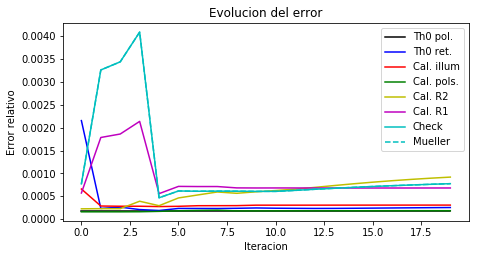

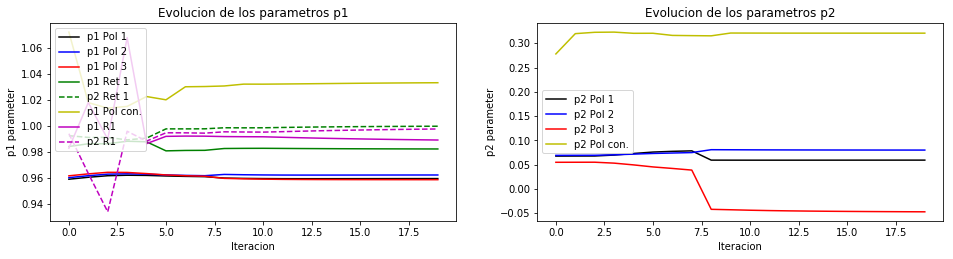

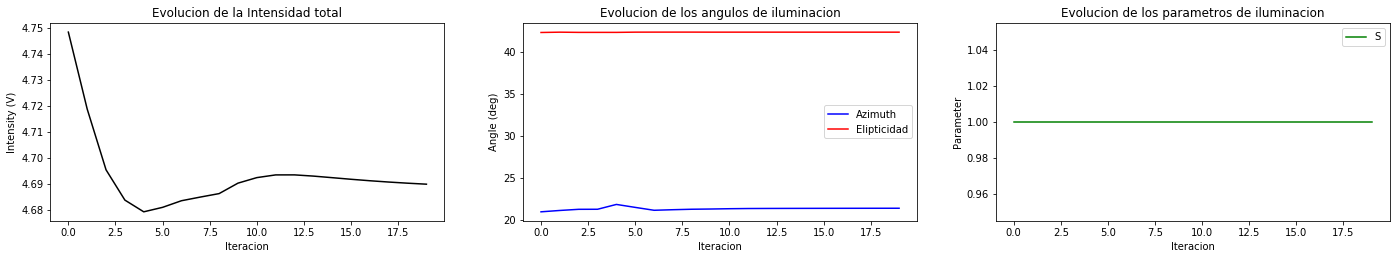

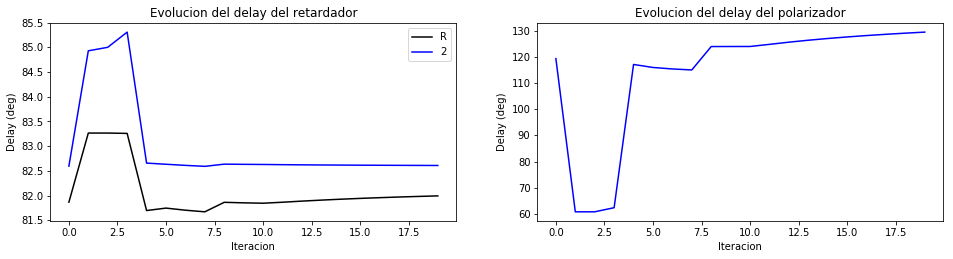

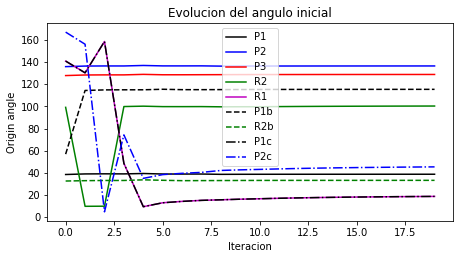

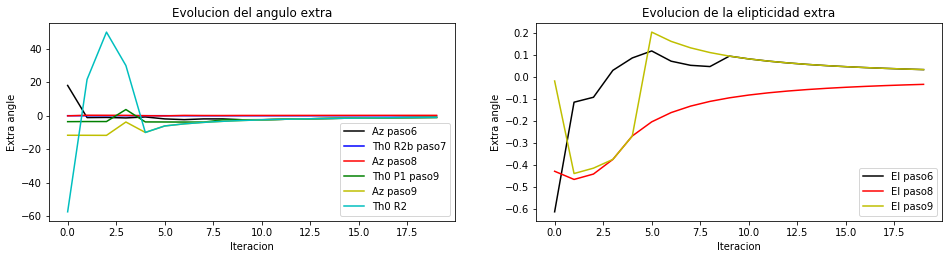

In [9]:
## Plot los resultados
# Plot errores
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(errores[0:indIt+1,0],'k')
plt.plot(errores[0:indIt+1,1],'b')
plt.plot(errores[0:indIt+1,2],'r')
plt.plot(errores[0:indIt+1,3],'g')
plt.plot(errores[0:indIt+1,4],'y')
plt.plot(errores[0:indIt+1,5],'m')
plt.plot(errores[0:indIt+1,6],'c')
plt.plot(errores[0:indIt+1,6],'c--')
plt.xlabel('Iteracion')
plt.ylabel('Error relativo')
plt.title('Evolucion del error')
plt.legend(('Th0 pol.', 'Th0 ret.', 'Cal. illum', 'Cal. pols.', 'Cal. R2', 'Cal. R1', 'Check', 'Mueller'))

# Plot pes
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(pes[0:indIt+1,0],'k')
plt.plot(pes[0:indIt+1,2],'b')
plt.plot(pes[0:indIt+1,4],'r')
plt.plot(pes[0:indIt+1,6],'g')
plt.plot(pes[0:indIt+1,7],'g--')
plt.plot(pes[0:indIt+1,8],'y')
plt.plot(np.abs(pes[0:indIt+1,10]),'m')
plt.plot(np.abs(pes[0:indIt+1,11]),'m--')
plt.xlabel('Iteracion')
plt.ylabel('p1 parameter')
plt.title('Evolucion de los parametros p1')
plt.legend(('p1 Pol 1',  'p1 Pol 2', 'p1 Pol 3','p1 Ret 1', 'p2 Ret 1', 'p1 Pol con.', 'p1 R1', 'p2 R1' ))

plt.subplot(2, 2, 2)
plt.plot(pes[0:indIt+1,1],'k')
plt.plot(pes[0:indIt+1,3],'b')
plt.plot(pes[0:indIt+1,5],'r')
plt.plot(pes[0:indIt+1,9],'y')
plt.xlabel('Iteracion')
plt.ylabel('p2 parameter')
plt.title('Evolucion de los parametros p2')
plt.legend(('p2 Pol 1', 'p2 Pol 2', 'p2 Pol 3', 'p2 Pol con.' ))

# Illums
plt.figure(figsize=(24, 8))
plt.subplot(2, 3, 1)
plt.plot(ilums[0:indIt+1,0],'k')
plt.xlabel('Iteracion')
plt.ylabel('Intensity (V)')
plt.title('Evolucion de la Intensidad total')

plt.subplot(2, 3, 2)
plt.plot(ilums[0:indIt+1,1]/degrees,'b')
plt.plot(ilums[0:indIt+1,2]/degrees,'r')
plt.xlabel('Iteracion')
plt.ylabel('Angle (deg)')
plt.title('Evolucion de los angulos de iluminacion')
plt.legend(('Azimuth', 'Elipticidad'))

plt.subplot(2, 3, 3)
plt.plot(ilums[0:indIt+1,3],'g')
plt.xlabel('Iteracion')
plt.ylabel('Parameter')
plt.title('Evolucion de los parametros de iluminacion')
plt.legend(('S_I' 'S_circ'))

# Delays
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(delays[0:indIt+1,0]/degrees,'k')
plt.plot(delays[0:indIt+1,2]/degrees,'b')
plt.xlabel('Iteracion')
plt.ylabel('Delay (deg)')
plt.title('Evolucion del delay del retardador')
plt.legend(('R2' 'R1'))

plt.subplot(2, 2, 2)
plt.plot(delays[0:indIt+1,1]/degrees,'b')
plt.xlabel('Iteracion')
plt.ylabel('Delay (deg)')
plt.title('Evolucion del delay del polarizador')

# Angles
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(fangles[0:indIt+1,0]/degrees,'k')
plt.plot(fangles[0:indIt+1,1]/degrees,'b')
plt.plot(fangles[0:indIt+1,2]/degrees,'r')
plt.plot(fangles[0:indIt+1,3]/degrees,'g')
plt.plot(fangles[0:indIt+1,6]/degrees,'m')
plt.plot(fangles[0:indIt+1,4]/degrees,'k--')
plt.plot(fangles[0:indIt+1,5]/degrees,'g--')
plt.plot(fangles[0:indIt+1,6]/degrees,'k-.')
plt.plot(fangles[0:indIt+1,7]/degrees,'b-.--')
plt.xlabel('Iteracion')
plt.ylabel('Origin angle')
plt.title('Evolucion del angulo inicial')
plt.legend(('P1', 'P2', 'P3', 'R2', 'R1', 'P1b', 'R2b', 'P1c', 'P2c'))

# Errangles
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(errangles[0:indIt+1,0]/degrees,'k')
plt.plot(errangles[0:indIt+1,2]/degrees,'b')
plt.plot(errangles[0:indIt+1,3]/degrees,'r')
plt.plot(errangles[0:indIt+1,5]/degrees,'g')
plt.plot(errangles[0:indIt+1,6]/degrees,'y')
plt.plot(errangles[0:indIt+1,8]/degrees,'c')
plt.xlabel('Iteracion')
plt.ylabel('Extra angle')
plt.title('Evolucion del angulo extra')
plt.legend(('Az paso6', 'Th0 R2b paso7', 'Az paso8', 'Th0 P1 paso9', 'Az paso9', 'Th0 R2'))
plt.subplot(2, 2, 2)
plt.plot(errangles[0:indIt+1,1]/degrees,'k')
plt.plot(errangles[0:indIt+1,4]/degrees,'r')
plt.plot(errangles[0:indIt+1,7]/degrees,'y')
plt.xlabel('Iteracion')
plt.ylabel('Extra angle')
plt.title('Evolucion de la elipticidad extra')
plt.legend(('El paso6', 'El paso8', 'El paso9'))

### Salvar los datos

In [10]:
polarimetro = {"p11": np.abs(pes[-1,0])}
polarimetro["p12"] = np.abs(pes[-1,1])
polarimetro["Dp1"] = delays[-1,1]
polarimetro["p21"] = np.abs(pes[-1,2])
polarimetro["p22"] = np.abs(pes[-1,3])
polarimetro["p31"] = np.abs(pes[-1,4])
polarimetro["p32"] = np.abs(pes[-1,5])
polarimetro["th0p1"] = fangles[-1,0]
polarimetro["th0p2"] = fangles[-1,1]
polarimetro["th0p1c"] = fangles[-1,6]
polarimetro["th0p2c"] = fangles[-1,7]

polarimetro["R1p1"] = np.abs(pes[-1,6])
polarimetro["R1p2"] = np.abs(pes[-1,7])
polarimetro["R2p1"] = np.abs(pes[-1,10])
polarimetro["R2p2"] = np.abs(pes[-1,11])
polarimetro["Dr1"] = delays[-1,2]
polarimetro["Dr2"] = delays[-1,0]
polarimetro["th0r1"] = fangles[-1,4]
polarimetro["th0r2"] = fangles[-1,3]

polarimetro["normal"] = mean[1]

polarimetro["Ifuente"] = Ifuente
polarimetro["Mp1"] = Mp1
polarimetro["Mp2"] = Mp2
polarimetro["Mr1"] = Mr1
polarimetro["Mr1"] = Mr2

# Save data
filename="Calibracion_polarimetro_{}".format(datetime.date.today())
np.savez(filename+'.npz', polarimetro=polarimetro)

## Medir matriz de Mueller del vacio

[[ 1.          0.          0.          0.        ]
 [ 0.          0.9028655  -0.01727936  0.01349777]
 [ 0.          0.01923356  0.92134016  0.11863458]
 [ 0.         -0.0265228   0.00402264  0.97655634]]
0.01114825270739684


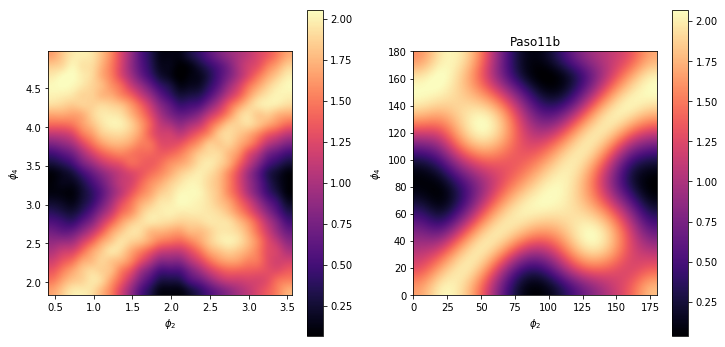

In [155]:
# Calculo matriz de mueller
th0 = [th0p1c, th0r1, th0r2, th0p2c+pi/2]
angles_Mueller = dist_angulos(angles2x*degrees,angles2y*degrees, th0)
I_mueller = Iexperimental.flatten()
Mme = [Mp1, Mr1, Mr2, Mp2]
Mcalculated = opsys.polarimeter_experiment(Mme, Ifuente, I_mueller, angles_Mueller)
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.01, verbose=False)
Mtarget = np.eye(4)
error_mat = Mfiltered - Mtarget
error_mat = np.linalg.norm(error_mat) / error_mat.size
print(Mfiltered)
print(error_mat)
# Figure
plt.figure(figsize=(12, 6))       
plt.subplot(1,2,1)
plot_2d_scattered(angles_Mueller[1,:], angles_Mueller[2,:],I_mueller, xy_are_angles=False)    
plt.subplot(1,2,2)
plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso11b')   

### Test script externo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Carga de datos finalizada
Iteracion 0
Error del ultimo paso: 0.00115022142621.
Iteracion 1
Error del ultimo paso: 0.00698388609873.
Iteracion 2
Error del ultimo paso: 0.0069858279726.
Iteracion 3
Error del ultimo paso: 0.00698595064251.
Iteracion 4
Error del ultimo paso: 0.00710404548549.
Iteracion 5
Error del ultimo paso: 0.00697978184223.
Iteracion 6
Error del ultimo paso: 0.00688957674077.
Iteracion 7
Error del ultimo paso: 0.00681417729566.
Iteracion 8
Error del ultimo paso: 0.00669535176146.
Iteracion 9
Error del ultimo paso: 0.00659888044036.
Iteracion 10
Error del ultimo paso: 0.00651930558117.
Iteracion 11
Error del ultimo paso: 0.00645224604982.
Iteracion 12
Error del ultimo paso: 0.00639503714679.
Iteracion 13
Error del ultimo paso: 0.00599114323107.
Iteracion 14
Error del ultimo paso: 0.00594888789751.
Iteracion 15
Error del ultimo paso: 0.00593358211697.
Iteracion 16
Error del ultimo pas

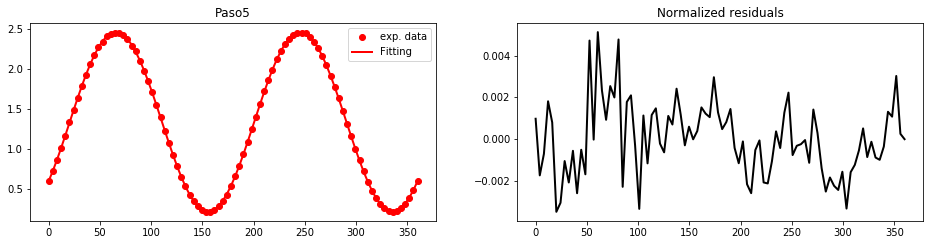

Parametros del paso 6
Th0r2b = 33.8941599983 deg; Th0E_az = -0.88382130412 deg; Th0E_el = -0.110106273476 deg;
Error del paso 6: 0.000196399790637.


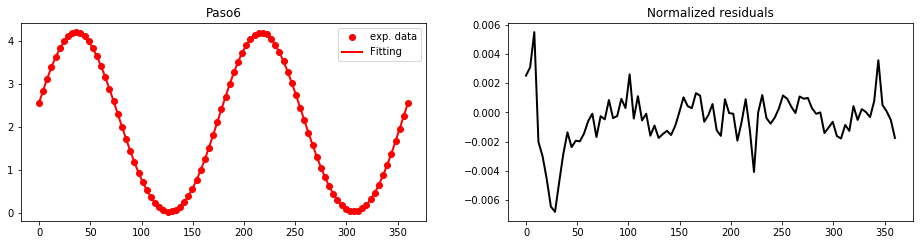

Parametros del paso 7
S0 = 4.67632745973 V; Azimuth = 202.110324367 deg; Ellipticity = 47.6560768393 deg; Pol. degree = 1.0; Th0_error = 0.0554539565882 deg;
Error del paso 7: 0.000257185301991.
Parametros del paso 8
p11 = 0.961637250755; p12 = 0.0770646415499; p21 = 0.962414094295; p22 = 0.0737602812931; p31 = 0.962239148507; p32 = 0.0435236302467;
Th0p1 = 39.1333530362 deg; Th0p2 = 136.81117404 deg; Th0p3 = 128.801743311 deg; Th0E_az = -0.524856760446 deg; Th0E_el = 0.15 deg;
Error del paso 8: 0.000189521872859.


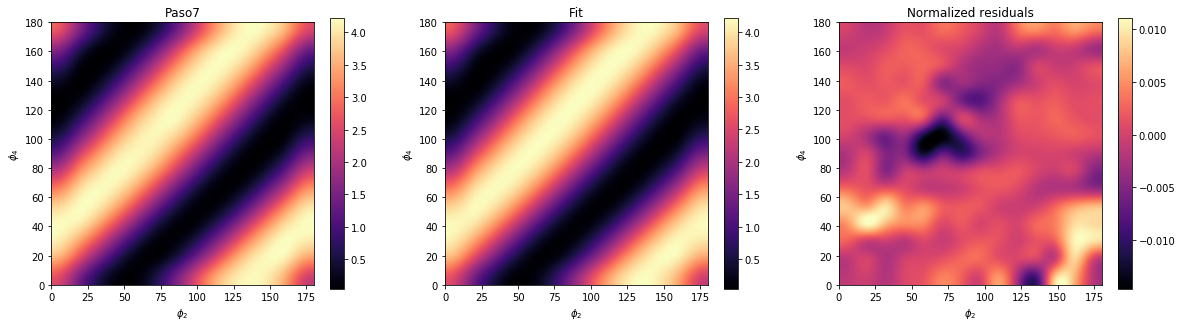

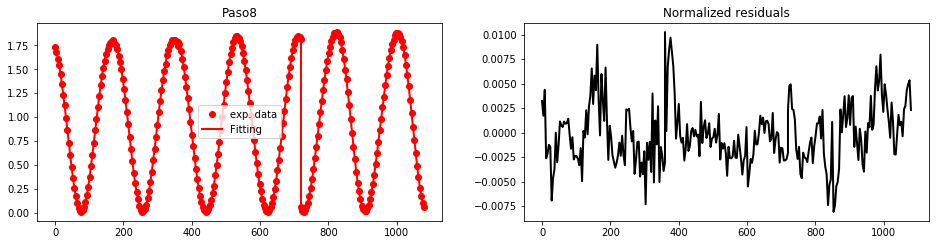

Parametros del paso 9
R2p1 = 0.99620501028; R2p2 = 0.982475627995; Delay_R2 = 83.0046786733; Th0_R2 = 10.3055389912; Delay_p1 = 65.0869592458;
Th0_error = -3.51681920333; Th0E_az = -4.5; Th0E_az = -0.15;
Error del paso 9: 0.000621247523258.
Parametros del paso 11a
R1p1 = 1.06466351941; R1p2 = 1.00475782757; Delay_R1 = 84.6128649288; Th0_R1 = 113.629884116;
Error del paso 11a: 0.00177714271351.
Error del paso 11b: 0.00343997796666.
La matriz del vacio sin filtrar es:
[[ 1.01972226  0.00719429  0.00232574 -0.00270841]
 [ 0.0063577   0.93939797 -0.01541901 -0.01442423]
 [-0.0332271   0.01755772  0.96105055 -0.12622207]
 [-0.01463904  0.02838446 -0.00389374  1.00878317]]
Error matriz del vacio: [[ 0.01972226  0.00719429  0.00232574 -0.00270841]
 [ 0.0063577  -0.06060203 -0.01541901 -0.01442423]
 [-0.0332271   0.01755772 -0.03894945 -0.12622207]
 [-0.01463904  0.02838446 -0.00389374  0.00878317]].

La matriz del vacio filtrada es:
[[ 0.99241148  0.00756346  0.0006162   0.        ]
 [-0.0075

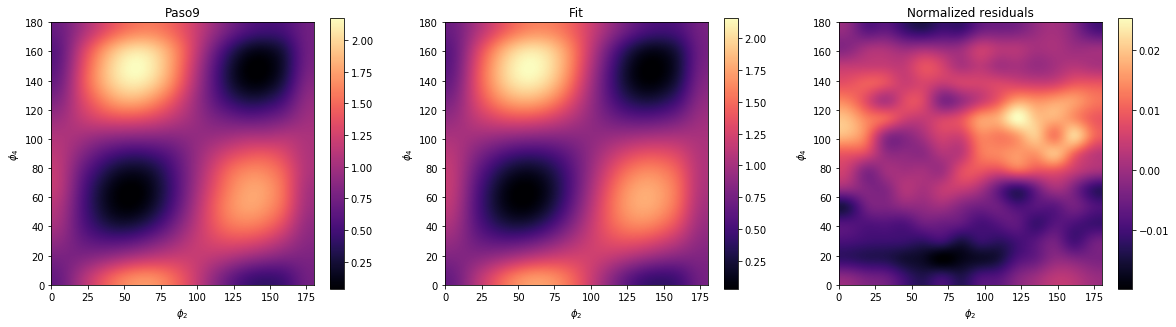

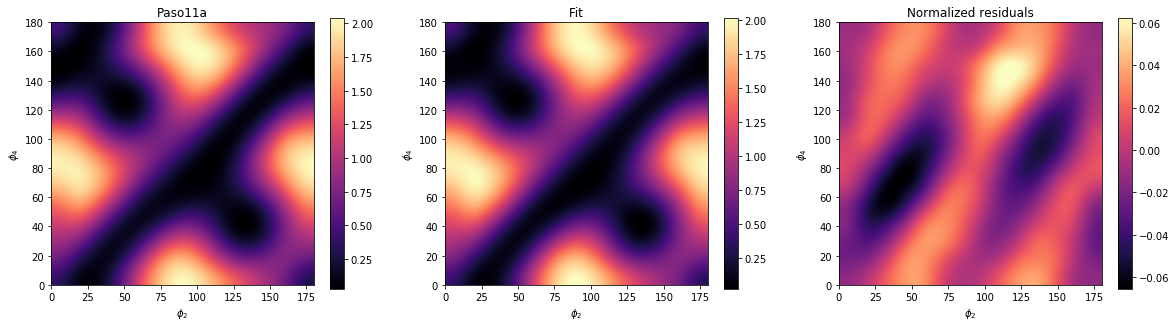

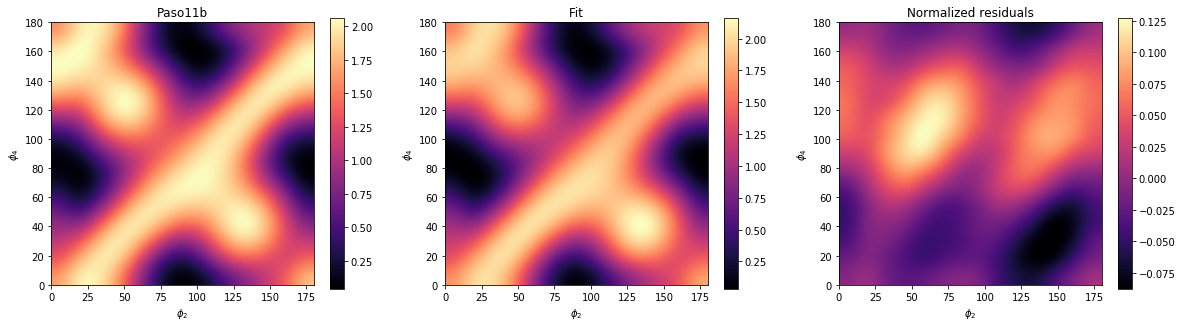

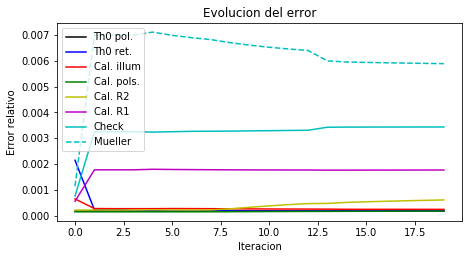

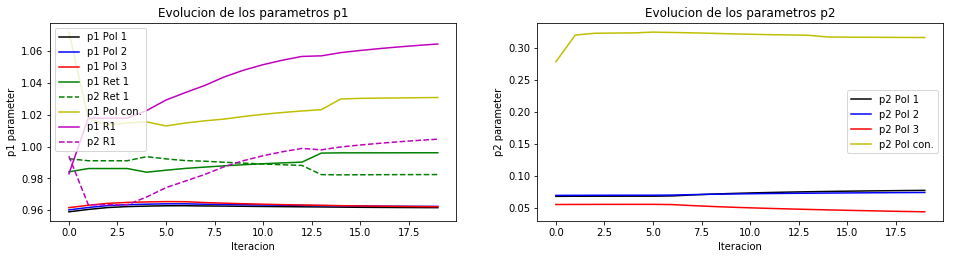

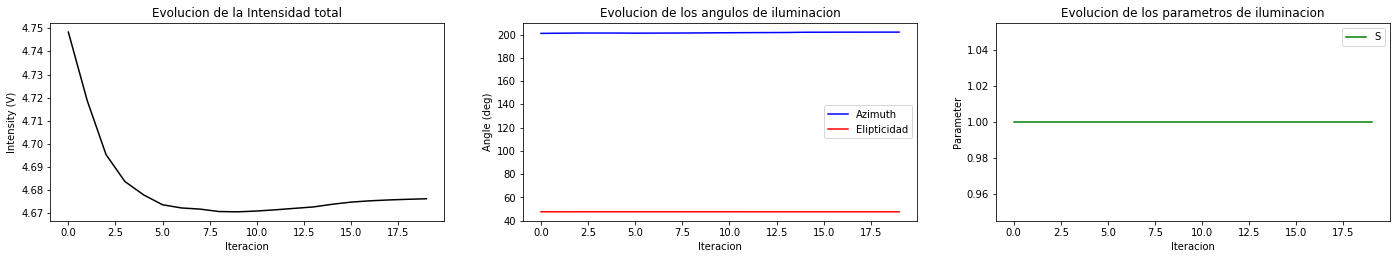

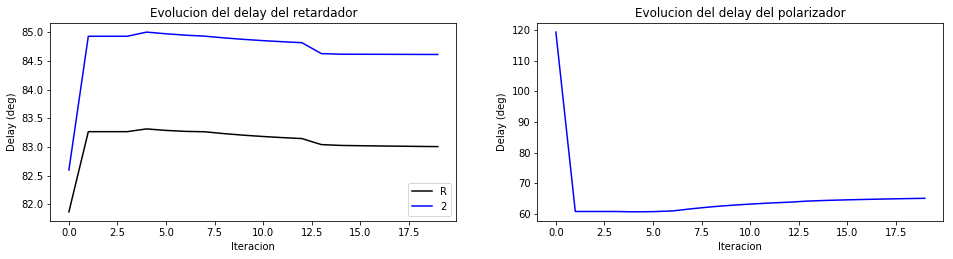

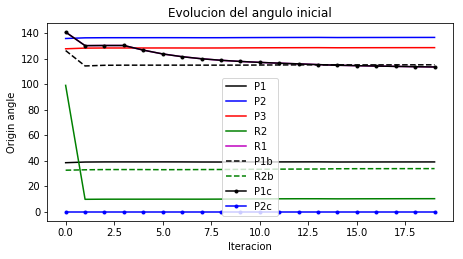

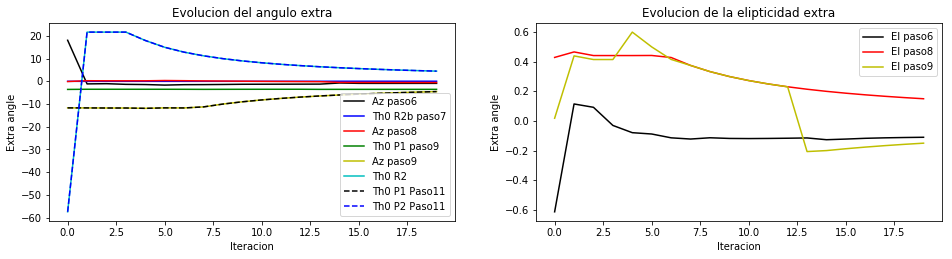

In [9]:
%load_ext autoreload
%autoreload 2

from polarimeter.data_process import process_calibration_alternative

params = {}
params["NmaxIteraciones"] = 20
params["tolerancia"] = 1e-4
params["PlotCadaPaso"] = False
params["ordenarPes"] = True
params["tol_while"] = 2.5e-4
params["N_it_while"] = 12
params["use_random_angles"] = True
params["fix_parameters"] = True
params["hacer_paso_11"] = True
params["save_data"] = True

pol_dict = process_calibration_alternative('2018-12-21', params)

## Ajustes individuales 

Para ver si se puede mejorar a mano.

### Primera iteracion

Parametros del paso 5
pc1 = 1.09070690168; pc2 = 0.273387249795; Th0p1b = 114.407656401 deg;
Error del paso 5: 0.00177205461833.


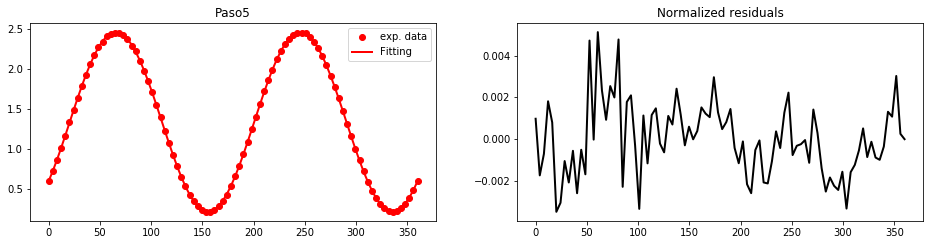

In [19]:
# Parametros del bucle
PlotCadaPaso = True
errAmpIt = 10*degrees
# Parametros iniciales
(p11, p12, pc1, pc2) = (0.95, 0.15, 0.95, 0.4)
(R2p1, R2p2, Dr2) = (0.99, 0.99, 85*degrees)
Mp1 = ps.polarizer_linear(p1=p11, p2=p12)
(Ilum0, Ilum1, Ilum2, Ilum3) = (mean[0], 0, 0, mean[0])
Ifuente = np.matrix(np.array([[Ilum0], [Ilum1], [Ilum2], [Ilum3]]))
th0p1b = 0

def model_paso5(par, th1): 
    # Create Jones matrices
    Mpmalo = ps.polarizer_linear(p1=par[0], p2=par[1])
    M = [Mpmalo, Mp1]
    th = [0, th1+par[2]]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Ifuente)
    return Iteor
def err_paso5(par, th1, Ireal): 
    Iteor = model_paso5(par, th1)
    diferencia = Iteor - Ireal
    return diferencia

# Update error amplitude for the current iteration
errAmpIt = 10*degrees
## Comenzar por ajustar el angulo de P1 en el motor 4 (Paso 5)
# Parametros iniciales
par0 = [pc1, pc2, th0p1b]
# Normalizacion de intensidades experimentales en funcion de la referencia
Iexperimental = Intensity_Paso5[:,0] * Intensity_Paso5[:,1]/mean[1]
# Ajuste
par1, success = optimize.leastsq(err_paso5, par0, args=(angle1*degrees, Iexperimental))
# Extraer resultados
th0p1b = par1[2]%pi
# Calculo de errores
error_Paso5 = err_paso5(par1, angle1*degrees, Iexperimental)
error_Paso5 = np.std(error_Paso5) / Iexperimental.max()
# Plots
if PlotCadaPaso:
    print("Parametros del paso 5")
    print("pc1 = {}; pc2 = {}; Th0p1b = {} deg;".format(par1[0], par1[1], (par1[2]%pi)/degrees))
    print("Error del paso 5: {}.".format(error_Paso5))
    I_fit = model_paso5(par1, angle1*degrees)
    plot_experiment_residuals_1D(angle1*degrees, Iexperimental, I_fit,  title='Paso5')

Parametros del paso 6
Th0r2b = 32.6192742099 deg; Th0_error = 0.0 deg;
Error del paso 6: 0.0238653924595.


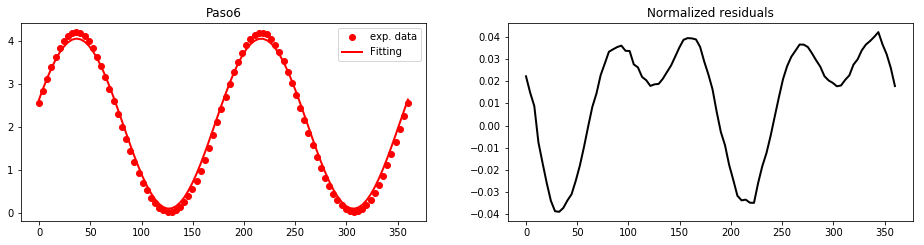

In [20]:
## Ahora el del retardador 2 la primera vez que lo metimos (Paso 6)
def model_paso6(par, th1): 
    # Create Jones matrices
    M = [Mr2, Mp1]
    th_error = errAmpIt * erf(par[1])
    Ipaso6 = ps.rotate_stokes(Ifuente, th_error)
    th = [th1+par[0], +th0p1b]
    Iteor = Intensity_Rotating_Elements(M, th, Ei = Ipaso6)
    return Iteor
def err_paso6(par, th1, Ireal): 
    Iteor = model_paso6(par, th1)
    diferencia = Iteor - Ireal
    return diferencia

# Parametros iniciales
(R2p1, R2p2, Dr2) = (0.99, 0.99, 85*degrees)
Mr2 = ps.Mueller_Real_Retarder(R2p1, R2p2, Dr2)
(th0r2b, th0E0) = (0, 0)

# Parametros iniciales
par0 = [th0r2b, th0E0]
# Normalizacion de intensidades experimentales en funcion de la referencia
Iexperimental = Intensity_Paso6[:,0] * Intensity_Paso6[:,1]/mean[1]
# Ajuste
par1, success = optimize.leastsq(err_paso6, par0, args=(angle1*degrees, Iexperimental))
# Extraer resultados
th0r2b = par1[0]%pi
th_error = errAmpIt * erf(par1[1])
# Calculo de errores
error_Paso6 = err_paso6(par1, angle1*degrees, Iexperimental)
error_Paso6 = np.std(error_Paso6) / Iexperimental.max()
# Plots
if PlotCadaPaso:
    print("Parametros del paso 6")
    print("Th0r2b = {} deg; Th0_error = {} deg;".format((par1[0]%pi)/degrees, th_error/degrees))
    print("Error del paso 6: {}.".format(error_Paso6))
    I_fit = model_paso6(par1, angle1*degrees)
    plot_experiment_residuals_1D(angle1*degrees, Iexperimental, I_fit,  title='Paso6')

Parametros del paso 7
S_I = 4.79583638656; S_0 = 0.329560413841; S_45 = 0.291680852508; S_c = 4.77560035489; Th0_error = -0.0492846876805 deg;
Error del paso 7: 0.00530021956385.


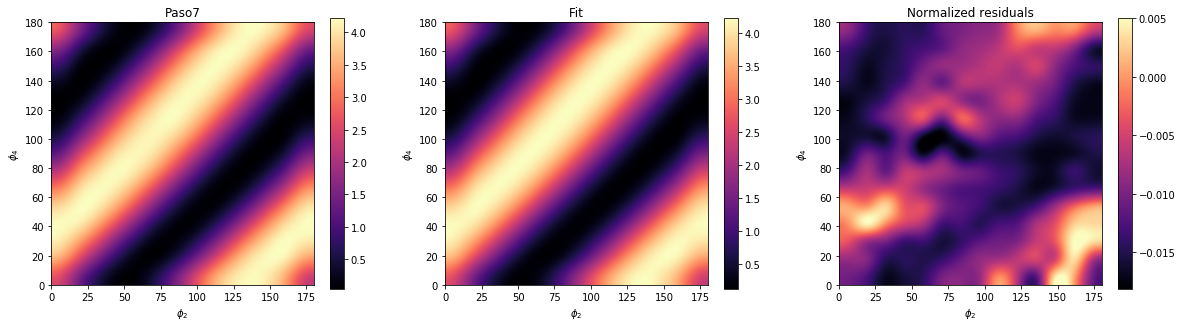

In [21]:
def model_paso7(par, th1, th2):
    # Conservacion de la energia
    Itotal = sqrt(par[1]**2 + par[2]**2 + par[3]**2)
    if Itotal > par[0]:
        par[0] = Itotal
    # Iluminacion y angulos
    th_error = errAmpIt * erf(par[4])
    Itest = np.matrix(np.array([[par[0]], [par[1]], [par[2]], [par[3]]]))    
    th = [th1+th0r2b, th2+th0p1b+th_error]      
    #th = [th1+par[4], th2+par[5]]
    M = [Mr2, Mp1]
    I = Intensity_Rotating_Elements(M, th, Itest, False)
    return I
def err_paso7(par, th1, th2, Ireal): 
    dI = model_paso7(par, th1, th2) - Ireal 
    return dI.flatten()

(Ilum0, Ilum1, Ilum2, Ilum3) = (mean[0], 0, 0, mean[0])

## Vamos a ajustar la iluminacion (Paso 7)
# Parametros iniciales
#par0 = [Ilum0, Ilum1, Ilum2, Ilum3]
par0 = [Ilum0, Ilum1, Ilum2, Ilum3, th0E0]
# Normalizacion de intensidades experimentales en funcion de la referencia
Iexperimental = Intensity_Paso7[:,:,0] * Intensity_Paso7[:,:,1]/mean[1]
#Iexperimental = np.transpose(Iexperimental)
# Ajuste
par1, success = optimize.leastsq(err_paso7, par0, args=(angles2x*degrees, angles2y*degrees, Iexperimental))
# Extraer resultados
(Ilum0, Imlum1, Ilum2, Ilum3) = (par1[0], par1[1], par1[2], par1[3])
Ifuente = np.matrix(np.array([[Ilum0], [Ilum1], [Ilum2], [Ilum3]]))
th_error = errAmpIt * erf(par1[4])
# Calculo de errores
error_Paso7 = err_paso7(par1, angles2x*degrees, angles2y*degrees, Iexperimental)
error_Paso7 = np.std(error_Paso7) / Iexperimental.max()
# Plots
if PlotCadaPaso:
    print("Parametros del paso 7")
    print("S_I = {}; S_0 = {}; S_45 = {}; S_c = {}; Th0_error = {} deg;".format(par1[0], par1[1], par1[2], par1[3], th_error/degrees))
    print("Error del paso 7: {}.".format(error_Paso7))
    I_fit = model_paso7(par1, angles2x*degrees, angles2y*degrees) 
    plt.figure(figsize=(20, 5))       
    plt.subplot(1,3,1)
    plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso7')    
    plt.subplot(1,3,2)
    plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
    plt.subplot(1,3,3)
    plot_2d(angles2x*degrees, angles2y*degrees,  (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
    

Parametros del paso 8
p11 = 0.173464976861; p12 = 0.937296084254; p21 = 0.932932008178; p22 = 4.39485452306e-05; p31 = 0.914022994579; p32 = 0.115687961145;
Th0p1 = 34.0408256206 deg; Th0p2 = 45.1275403535 deg; Th0p3 = 37.466021624 deg; Th0_error = 20.0 deg;
Error del paso 8: 0.0204526321658.


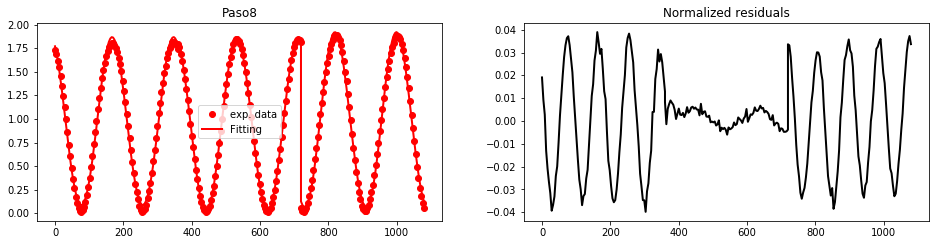

In [29]:
def model_paso8(par, th1a, th1b, th1c): 
    # Create Jones matrices
    Mp1 = ps.polarizer_linear(p1=par[0], p2=par[1])
    Mp2 = ps.polarizer_linear(p1=par[2], p2=par[3])
    Mp3 = ps.polarizer_linear(p1=par[4], p2=par[5])
    th_error = errAmpIt * erf(par[9])
    Ipaso8 = ps.rotate_stokes(Ifuente, th_error)
    # First, P3 and P1   
    M = [Mp3, Mp1]
    th = [th1a+par[6], +th0p1b]
    Ia = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # Then, P3 and P2   
    M = [Mp3, Mp2]
    th = [+par[6], th1b+par[7]]
    Ib = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # Last, P1 and P2  
    M = [Mp1, Mp2]
    th = [th1c+par[8], +par[7]]
    Ic = Intensity_Rotating_Elements(M, th, Ei = Ipaso8)
    # End
    return (Ia, Ib, Ic)
def err_paso8(par, th1a, th1b, th1c, IRa, IRb, IRc): 
    (Ia, Ib, Ic) = model_paso8(par, th1a, th1b, th1c)
    dIa = Ia - IRa
    dIb = Ib - IRb
    dIc = Ic - IRc
    dI = np.concatenate((dIa, dIb, dIc))
    return dI

(p11, p12, Dp1, p21, p22, p31, p32) = (0.95, 0.15, 0*degrees, 0.95, 0.15, 0.95, 0.15)
(th0p1, th0p2, th0p3) = (0, 0, 0)
errAmpIt = 20*degrees

## Ahora vamos a por los polarizadores (Paso 8)
# Parametros iniciales
par0 = [p11, p12, p21, p22, p31, p32, th0p3, th0p2, th0p1, th0E0]
# Normalizacion de intensidades experimentales en funcion de la referencia 
IexpA = Intensity_Paso8a[:,0] * Intensity_Paso8a[:,1]/mean[1]
IexpB = Intensity_Paso8b[:,0] * Intensity_Paso8b[:,1]/mean[1]
IexpC = Intensity_Paso8c[:,0] * Intensity_Paso8c[:,1]/mean[1]
# Ajuste
par1, success = optimize.leastsq(err_paso8, par0, args=(
    angle1*degrees, angle1*degrees, angle1*degrees, IexpA, IexpB, IexpC))
# Extraer resultados
(p11, p12, p21, p22, p31, p32) = (par1[0], par1[1], par1[2], par1[3], par1[4], par1[5])
(th0p3, th0p2, th0p1) = (par1[6]%pi, par1[7]%pi, par1[8]%pi)
Mp2 = ps.polarizer_linear(p1=p21, p2=p22)
th_error = errAmpIt * erf(par1[9])
# Calculo de errores
error_Paso8 = err_paso8(par1, angle1*degrees, angle1*degrees, angle1*degrees, IexpA, IexpB, IexpC)
maxval = np.array([IexpA.max(), IexpB.max(), IexpC.max()]).max()
error_Paso8 = np.std(error_Paso8) / maxval
# Plots
if PlotCadaPaso:
    print("Parametros del paso 8")
    print("p11 = {}; p12 = {}; p21 = {}; p22 = {}; p31 = {}; p32 = {};".format(par1[0], par1[1], par1[2], par1[3], par1[4], par1[5]))
    print("Th0p1 = {} deg; Th0p2 = {} deg; Th0p3 = {} deg; Th0_error = {} deg;".format((par1[8]%pi)/degrees, (par1[7]%pi)/degrees, (par1[6]%pi)/degrees, th_error/degrees))
    print("Error del paso 8: {}.".format(error_Paso8))
    I_fit = model_paso8(par1, angle1*degrees, angle1*degrees, angle1*degrees)
    plot_experiment_residuals_1D(np.concatenate([angle1*degrees,angle1*degrees + 2*pi,angle1*degrees + 4*pi]), 
                       np.concatenate([IexpA,IexpB,IexpC]), 
                       np.concatenate((I_fit[0],I_fit[1],I_fit[2])),  title='Paso8')

Parametros del paso 9
R2p1 = 0.995616351948; R2p2 = 1.05050333285; Delay_R2 = 82.104557021; Th0_R2 = 8.78374148077; Delay_p1 = 78.5815578056; Th0_error = -6.63672140508; Th0_error2 = -20.0;
Error del paso 9: 0.0195966479809.


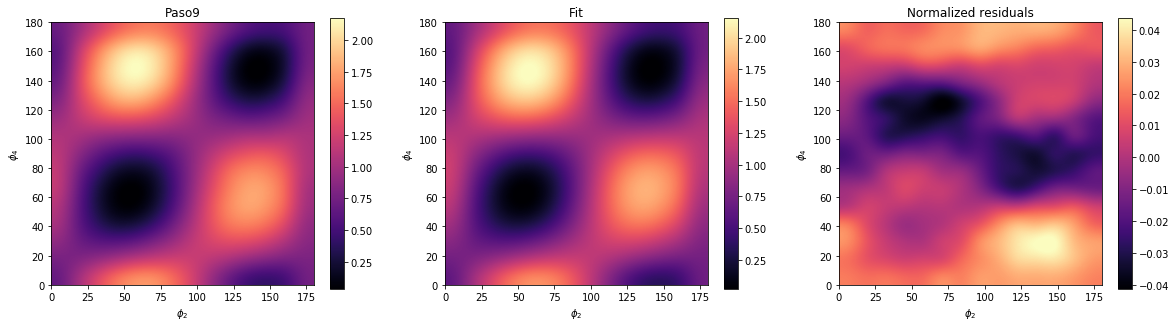

In [30]:
def model_paso9(par, th1, th2):
    Mr2 = ps.Mueller_Real_Retarder(par[0], par[1], par[2])
    Mp1 = ps.Mueller_Real_Retarder(p11, p12, par[4])
    th_error = errAmpIt * erf(par[5])
    th_error2 = errAmpIt * erf(par[6])
    Ipaso9 = ps.rotate_stokes(Ifuente, th_error2)
    M = [Mp1, Mr2, Mp2]
    th = [th1+th0p1+th_error, +par[3], th2+th0p2]
    I = Intensity_Rotating_Elements(M, th, Ipaso9, False)
    return I
def err_paso9(par, th1, th2, Ireal): 
    dI = model_paso9(par, th1, th2) - Ireal
    return dI.flatten()


(R2p1, R2p2, Dr2) = (0.99, 0.99, 85*degrees)
Dp1 = 0
th0r2 = 0
Mr2 = ps.Mueller_Real_Retarder(R2p1, R2p2, Dr2)
errAmpIt = 20*degrees

## Por último, ajustamos el retardador (Paso 9)
# Parametros iniciales
par0 = [R2p1, R2p2, Dr2, th0r2, Dp1, th0E0, th0E0]
# Normalizacion de intensidades experimentales en funcion de la referencia
Iexperimental = Intensity_Paso9[:,:,0] * Intensity_Paso9[:,:,1]/mean[1]
# Ajuste
par1, success = optimize.leastsq(err_paso9, par0, args=(angles2x*degrees, angles2y*degrees, Iexperimental))
# Extraer resultados
(R2p1, R2p2, Dr2, th0r2, Dp1) = (par1[0], par1[1], par1[2]%pi, par1[3]%pi, par1[4]%pi)
Mr2 = ps.Mueller_Real_Retarder(R2p1, R2p2, Dr2)
Mp1 = ps.Mueller_Real_Retarder(p11, p12, Dp1)
th_error = errAmpIt * erf(par1[5])
th_error2 = errAmpIt * erf(par1[6])
# Calculo de errores
error_Paso9 = err_paso9(par1, angles2x*degrees, angles2y*degrees, Iexperimental)
error_Paso9 = np.std(error_Paso9) / Iexperimental.max()
# Plots
if PlotCadaPaso or indIt+1 == NmaxIteraciones:
    print("Parametros del paso 9")
    print("R2p1 = {}; R2p2 = {}; Delay_R2 = {}; Th0_R2 = {}; Delay_p1 = {}; Th0_error = {}; Th0_error2 = {};".format(
        par1[0], par1[1], (par1[2]%pi)/degrees, (par1[3]%pi)/degrees, (par1[4]%pi)/degrees, th_error/degrees, th_error2/degrees))
    print("Error del paso 9: {}.".format(error_Paso9))
    I_fit = model_paso9(par1, angles2x*degrees, angles2y*degrees)        
    plt.figure(figsize=(20, 5))       
    plt.subplot(1,3,1)
    plot_2d(angles2x*degrees, angles2y*degrees, Iexperimental, title='Paso9')    
    plt.subplot(1,3,2)
    plot_2d(angles2x*degrees, angles2y*degrees, I_fit, title='Fit')    
    plt.subplot(1,3,3)
    plot_2d(angles2x*degrees, angles2y*degrees, (Iexperimental-I_fit)/Iexperimental.max(), title='Normalized residuals')
